In [1]:
import numpy as np
import torch
import torch_geometric
import networkx as nx
import matplotlib.pyplot as plt
from random import randint, shuffle
from collections import defaultdict

from torch_geometric.utils import from_networkx, to_networkx, remove_isolated_nodes, dropout_edge
from torch_geometric.loader import DataLoader
from torch_scatter import scatter_mean, scatter_std, scatter_min, scatter_max

from GOOD.utils.synthetic_data import synthetic_structsim
from GOOD.utils.args import args_parser, CommonArgs
from GOOD import config_summoner
from GOOD.kernel.main import initialize_model_dataset
from GOOD.kernel.pipeline_manager import load_pipeline
from GOOD.ood_algorithms.ood_manager import load_ood_alg
from GOOD.utils.initial import reset_random_seed
import GOOD.kernel.pipelines.xai_metric_utils as xai_utils
from GOOD.kernel.pipelines.basic_pipeline import CustomDataset

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.feature_selection import r_regression
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2


## Load models and dataset

In [2]:
DATASET = "TopoFeature/basis"
SEED = 1
DEVICE = "cuda:0"
MODEL = "GSAT"

In [3]:
args = CommonArgs(argv=None)
args.random_seed = SEED
args.exp_round = SEED
args.average_edge_attn = "mean"
args.use_norm = "none"
config_path = f"./final_configs/{DATASET}/no_shift/GSAT.yaml"
args.process_args_manual(config_path)
config = config_summoner(args)
config["mitigation_backbone"] = None
config["mitigation_sampling"] = "feat"
config["average_edge_attn"] = "mean"
config["task"] = "test"
config["device"] = DEVICE
gsat, loader = initialize_model_dataset(config)
gsat_ood_algorithm = load_ood_alg(config.ood.ood_alg, config)
gsat_pipeline = load_pipeline(config.pipeline, config.task, gsat, loader, gsat_ood_algorithm, config)
gsat_pipeline.load_task(load_param=True, load_split="id")
gsat_pipeline.model.eval()

model_dirname= repr_GSATGIN_3l_sumpool_0.0dp_mitig_backboneNone_mitig_samplingfeatnormnoneavgedgeattnmean
#IN#
-----------------------------------
    Task: test
Sat Nov  2 17:16:44 2024
#IN#Load Dataset TopoFeature
TopoFeature
loading:  /home/azzolin/sedignn/global_local_sedignn/storage/datasets/TopoFeature/basis/processed/data_BA_numgraphs5000_min8_max80_redmax4_requiredred2_shiftno_shift.pt
loading:  /home/azzolin/sedignn/global_local_sedignn/storage/datasets/TopoFeature/basis/processed/data_BA_numgraphs5000_min150_max250_redmax4_requiredred2_shiftsize.pt
loading:  /home/azzolin/sedignn/global_local_sedignn/storage/datasets/TopoFeature/basis/processed/data_ER_numgraphs5000_min8_max80_redmax4_requiredred2_shiftER.pt
#D#Dataset: {'train': TopoFeature(4000), 'id_val': TopoFeature(500), 'id_test': TopoFeature(500), 'metric': 'Accuracy', 'task': 'Binary classification', 'val': TopoFeature(5000), 'test': TopoFeature(5000)}
#D# Data(x=[78, 3], edge_index=[2, 296], y=[1, 1], pattern=[1], no

GSATGIN(
  (gnn): GINFeatExtractor(
    (encoder): GINEncoder(
      (relus): ModuleList(
        (0-2): 3 x ReLU()
      )
      (dropouts): ModuleList(
        (0-2): 3 x Dropout(p=0.0, inplace=False)
      )
      (readout): GlobalAddPool()
      (convs): ModuleList(
        (0-2): 3 x GINConvAttn()
      )
    )
  )
  (extractor): ExtractorMLP(
    (feature_extractor): MLP(
      (0): Linear(in_features=200, out_features=400, bias=True)
      (1): InstanceNorm(400)
      (2): ReLU()
      (3): Dropout(p=0.0, inplace=False)
      (4): Linear(in_features=400, out_features=100, bias=True)
      (5): InstanceNorm(100)
      (6): ReLU()
      (7): Dropout(p=0.0, inplace=False)
      (8): Linear(in_features=100, out_features=1, bias=True)
    )
  )
  (classifier): Classifier(
    (classifier): Sequential(
      (0): Linear(in_features=100, out_features=1, bias=True)
    )
  )
)

##### Check Model Accuracy

In [4]:
print("GSAT")
gsat_pipeline.evaluate("id_val", compute_suff=False);
gsat_pipeline.evaluate("test", compute_suff=False);

GSAT
Id_val ACCURACY: 1.0000 	Id_val Loss: 0.0005 	
Test ACCURACY: 0.8698 	Test Loss: 1.0155 	


In [5]:
if MODEL == "GSAT":
    tested_pipeline = gsat_pipeline
    tested_ood_algorithm = gsat_ood_algorithm
    tested_model = gsat
elif MODEL == "SMGNN":
    tested_pipeline = smgnn_pipeline
    tested_ood_algorithm = smgnn_ood_algorithm
    tested_model = smgnn

In [6]:
##
# Extract edge scores
##
IS_WEIGHT = True

ratios = [0.1, 0.3]
weights = [0.8, 0.90]
splits = ["id_val", "test"]

(edge_scores, graphs, graphs_nx, labels, avg_graph_size, \
    causal_subgraphs_r, spu_subgraphs_r, expl_accs_r, causal_masks_r)  = tested_pipeline.compute_scores_and_graphs(
        ratios if not IS_WEIGHT else weights,
        splits,
        convert_to_nx=True,
        log=True,
        is_weight=IS_WEIGHT
    )

TopoFeature(500)
Data example from id_val: Data(x=[57, 3], edge_index=[2, 212], y=[1, 1], pattern=[1], node_gt=[57], edge_gt=[212])
Label distribution from id_val: (tensor([0., 1.]), tensor([223, 277]))
F1 for r=0.8 = 0.000
WIoU for r=0.8 = 0.435
F1 for r=0.9 = 0.000
WIoU for r=0.9 = 0.388
TopoFeature(5000)
Data example from test: Data(x=[62, 3], edge_index=[2, 674], y=[1, 1], pattern=[1], node_gt=[62], edge_gt=[674])
Label distribution from test: (tensor([0., 1.]), tensor([2532, 2468]))
F1 for r=0.8 = 0.000
WIoU for r=0.8 = 0.400
F1 for r=0.9 = 0.000
WIoU for r=0.9 = 0.394


In [7]:
def predict_sample(graphs, pipeline, ratio):
    eval_set = CustomDataset("", graphs, torch.arange(len(graphs)))
    loader = DataLoader(eval_set, batch_size=256, shuffle=False, num_workers=0)
    preds, belonging = pipeline.evaluate_graphs(loader, log=True, weight=ratio, is_ratio=True, eval_kl=True)
    return preds

def get_tensor_pred(pred):
    return "[" + ", ".join([str(round(o.item(),3)) for o in pred]) + "]"


colors = {
    "inv": "green",
    "spu": "black",
    "added": "red"
}


def draw(config, G, name, subfolder="", pos=None, save=True, figsize=(6.4, 4.8), nodesize=350, with_labels=True, title=None, ax=None):
    if pos is None:
        pos = nx.kamada_kawai_layout(G)

    G = nx.Graph(G)

    edge_colors = list(map(lambda x: colors[x], nx.get_edge_attributes(G,'origin').values()))
    node_gt = list(nx.get_node_attributes(G, "node_gt").values())
    node_attr = list(nx.get_node_attributes(G, "ori_x").values())

    node_colors = []
    for i in range(len(node_attr)):
        if len(node_gt) > 0 and node_gt[i]:
            node_colors.append("orange") # "lightgreen"
        elif node_attr[i] == [1.0, 0., 0.]:
            node_colors.append("red")
        else:
            node_colors.append("orange")
    
    nx.draw(
        G,
        with_labels=with_labels,
        pos=pos,
        ax=ax,
        node_size=nodesize,
        node_color=node_colors,
        edge_color=edge_colors,
    )

    # Annotate with edge scores
    if nx.get_edge_attributes(G, 'attn_weight') != {}:
        nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'attn_weight'), font_size=6, alpha=0.8, ax=ax)
    
    if ax is None:
        plt.close()
    else:
        ax.set_title(title)
    return pos

## Inspecting some predictions

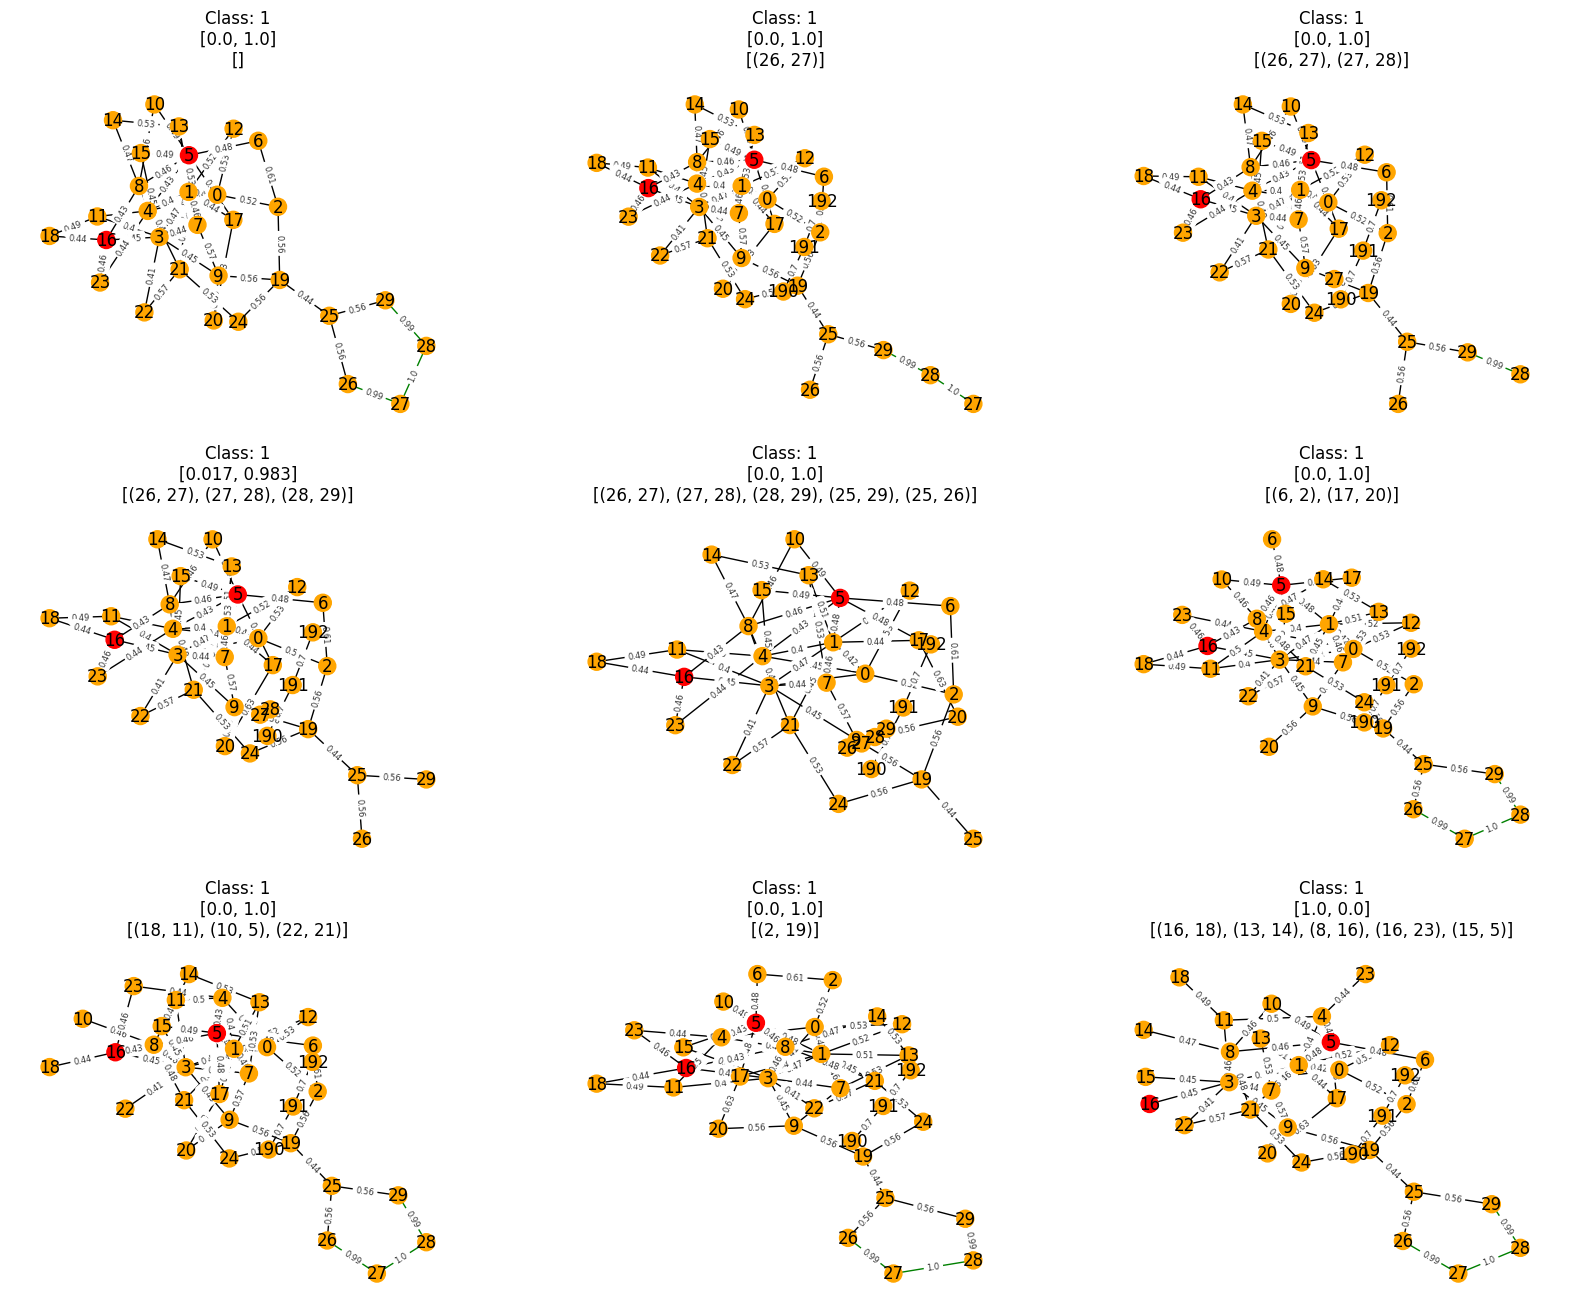

In [8]:
if IS_WEIGHT:
    ratio = weights[1]
else:
    ratio = ratios[0]
    
split = "id_val"
idx = 1 # 1 | 7

G = graphs_nx[split][idx].copy()
data = graphs[split][idx]
xai_utils.mark_edges(G, data.edge_index, data.edge_index[:, data.edge_gt == 1], inv_edge_w=edge_scores[split][idx]) # just to apply edge weight scores
xai_utils.mark_edges(G, causal_subgraphs_r[split][ratio][idx], spu_subgraphs_r[split][ratio][idx])

n_row, n_col = 3, 3
fig, axs = plt.subplots(n_row, n_col, figsize=(20,16))
for j in range(n_row * n_col):   
    ax = axs[j // n_col, j % n_col]


    edge_to_remove = []
    if j == 0:
        sample = G
    if j == 1:
        if idx == 1:
            edge_to_remove = [(26,27)]
        elif idx == 7:
            edge_to_remove = [(15,16)]
    if j == 2:
        if idx == 1:
            edge_to_remove = [(26, 27), (27,28)]
        elif idx == 7:
            edge_to_remove = [(13,14), (14,15)]
    if j == 3:
        if idx == 1:
            edge_to_remove = [(26, 27), (27,28), (28,29)]
        elif idx == 7:
            edge_to_remove = [(13,14), (14,15), (15,16)]
    if j == 4:
        if idx == 1:
            edge_to_remove = [(26, 27), (27,28), (28,29), (25,29), (25,26)]
        elif idx == 7:
            edge_to_remove = [(7,9), (4,5), (8,10)]
    if j == 5:
        if idx == 1:
            edge_to_remove = [(6,2), (17,20)]
        elif idx == 7:
            edge_to_remove = [(1,3), (1,0), (0,3)]
    if j == 6:
        if idx == 1:
            edge_to_remove = [(18,11), (10,5), (22, 21)]
    if j == 7:
        if idx == 1:
            edge_to_remove = [(2,19)]
    if j == 8:
        if idx == 1:
            edge_to_remove = [(16,18), (13,14), (8,16), (16,23), (15,5)]


    sample = G.copy()
    # REMOVE EDGES
    for e in edge_to_remove:
        sample.remove_edge(e[0], e[1])
        sample.remove_edge(e[1], e[0])

    if j > 0:
        sample.add_edge(190, 191, origin="spu", attn_weight=0.7, edge_gt=0)
        sample.add_edge(191, 190, origin="spu", attn_weight=0.7, edge_gt=0)
        sample.add_edge(191, 192, origin="spu", attn_weight=0.7, edge_gt=0)
        sample.add_edge(192, 191, origin="spu", attn_weight=0.7, edge_gt=0)
        sample.nodes[190]["ori_x"] = [0.,0.,1.]
        sample.nodes[191]["ori_x"] = [0.,0.,1.]
        sample.nodes[192]["ori_x"] = [0.,0.,1.]

    prediction = predict_sample([sample], tested_pipeline, ratio=None).exp()
    draw(
        config,
        sample,
        name="",
        save=False,
        figsize=(3, 3),
        nodesize=150, 
        with_labels=True,
        title=f"Class: {int(graphs[split][idx].y.item())}\n{get_tensor_pred(prediction[0])}\n{edge_to_remove}",
        ax=ax
    )
plt.show()

In [12]:
edge_scores.keys()


dict_keys(['train', 'id_val', 'id_test', 'test', 'val'])

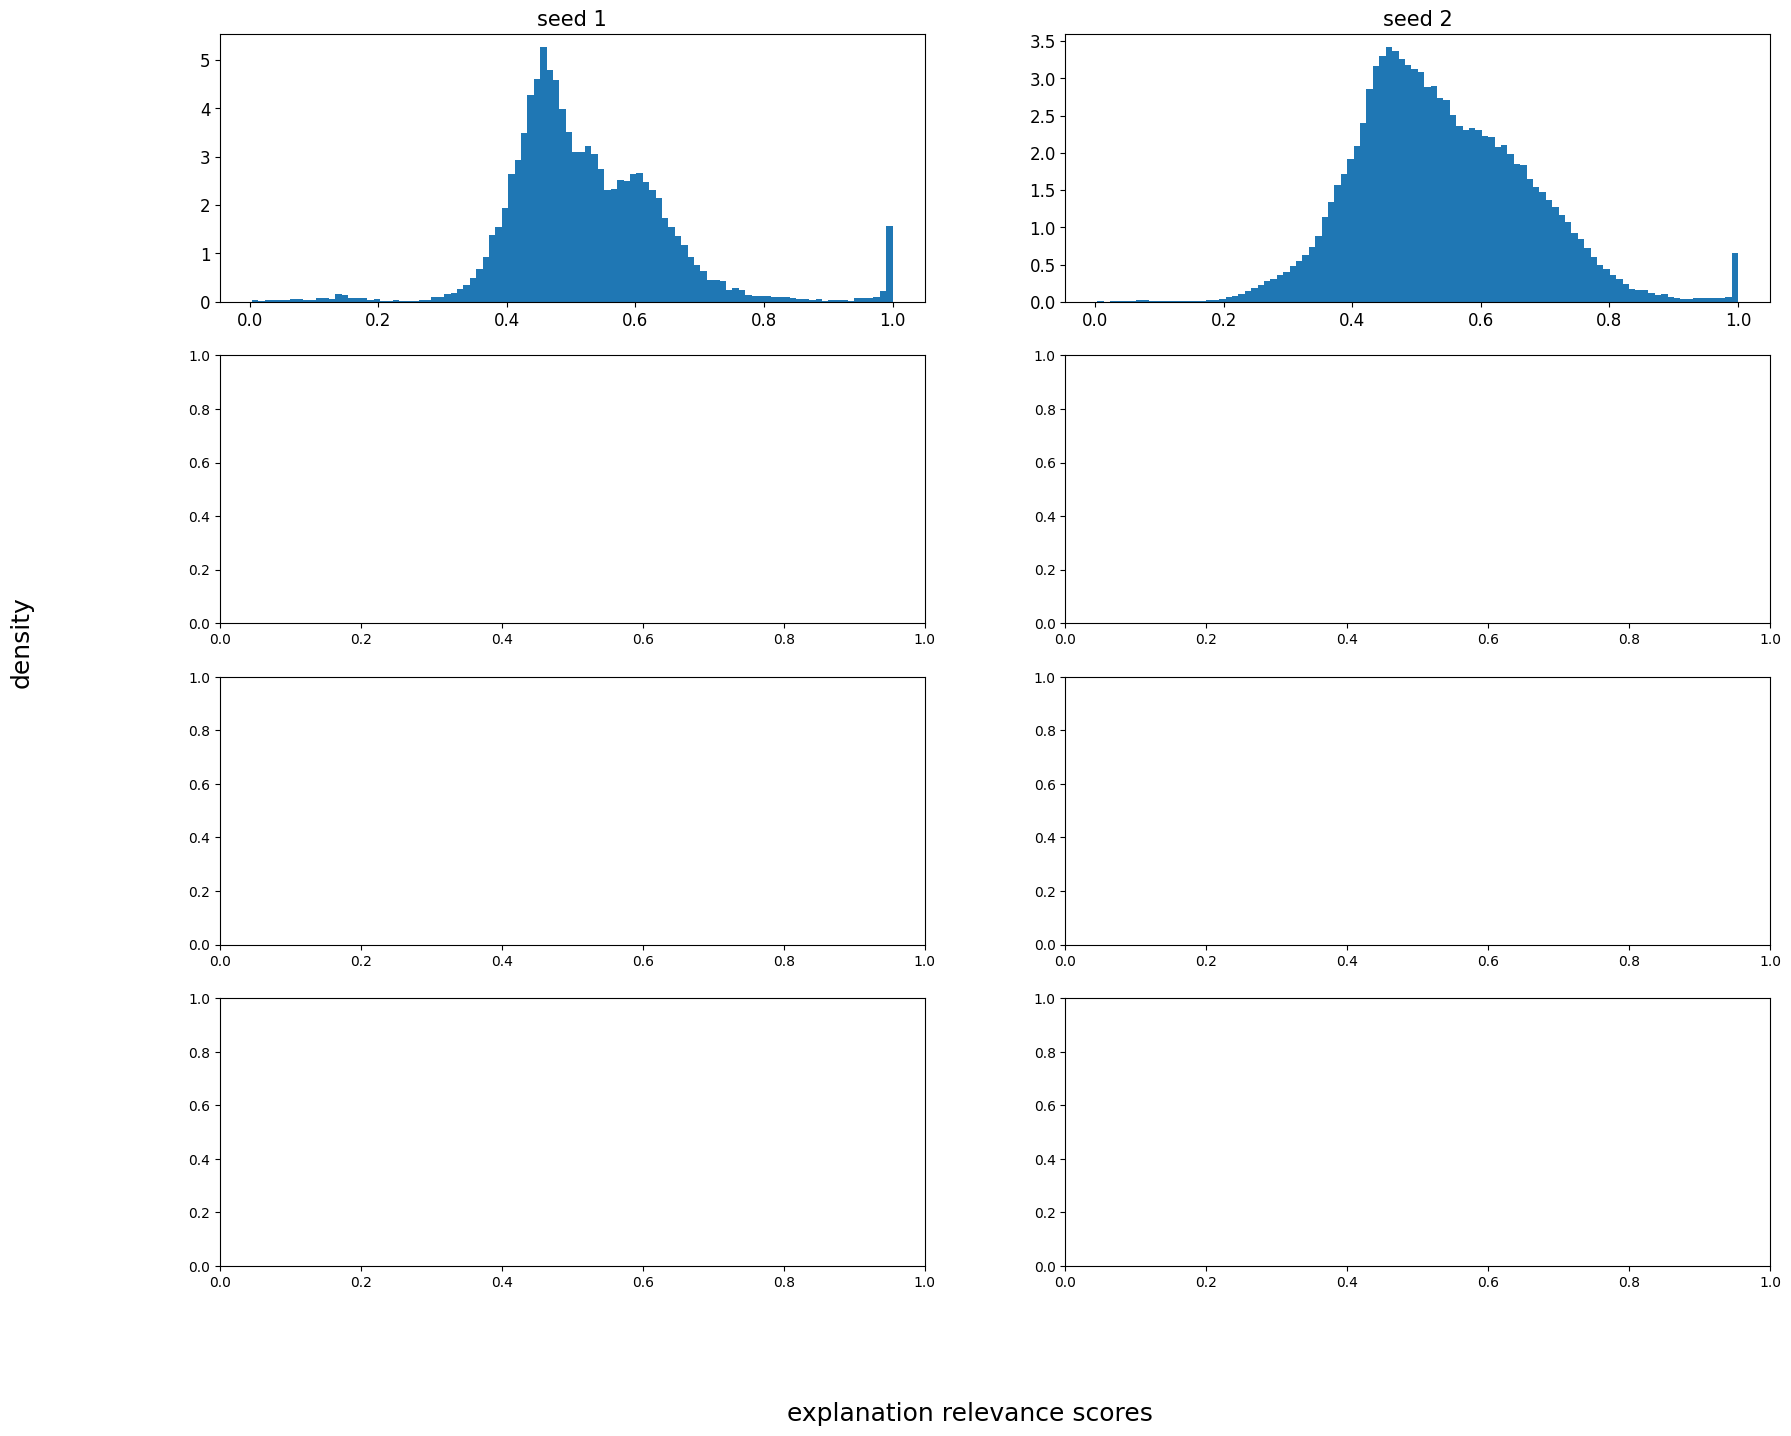

In [22]:
def generate_panel_all_seeds(self, edge_scores_seed):
    n_row, n_col = 4, 2
    fig, axs = plt.subplots(n_row, n_col, figsize=(20,16))
    for j in range(len(edge_scores_seed)):   
        ax = axs[j // n_col, j % n_col]

        ax.hist(np.concatenate(edge_scores_seed[j]), density=True, log=False, bins=100)
        ax.set_title(f"seed {j+1}", fontsize=15)
        ax.tick_params(axis='y', labelsize=12)
        ax.tick_params(axis='x', labelsize=12)
    fig.supxlabel('explanation relevance scores', fontsize=18)
    fig.supylabel('density', fontsize=18)
    plt.show()
generate_panel_all_seeds(None, [edge_scores["id_val"], edge_scores["test"]])

## SUFF - Manual Inspection

tensor([[2.4624e-03, 9.9725e-01, 2.8875e-04]])
GT: tensor([1])
Selected 393 relevant edges over 436


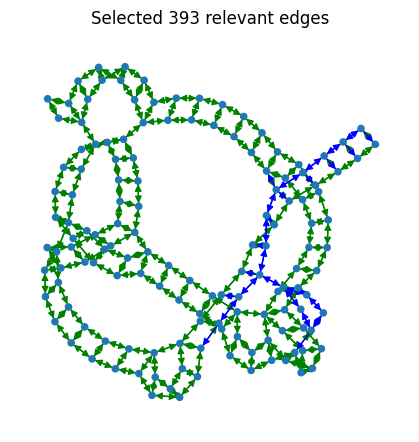

In [148]:
ratio = 0.9
idx = 4

G = graphs_nx[SPLIT][idx].copy()
xai_utils.mark_edges(G, causal_subgraphs_r[SPLIT][ratio][idx], spu_subgraphs_r[SPLIT][ratio][idx])

# G, _   = sample_edges(G, graphs[SPLIT][idx], None, spu_subgraphs_r[SPLIT][ratio][idx], ratio=1, num_to_remove=10, remove_undirected=False)

print(predict_sample([G], tested_pipeline, ratio=ratio).exp())
print(f"GT: {graphs[SPLIT][idx].y}")
pos = xai_utils.draw(config, G, name="", save=False, figsize=(4, 4), nodesize=20, with_labels=False);

Used  0
Used  1
Used  4
Used  4
Used  4
Used  5
Used  6
Used  8
Used  8
Used  10


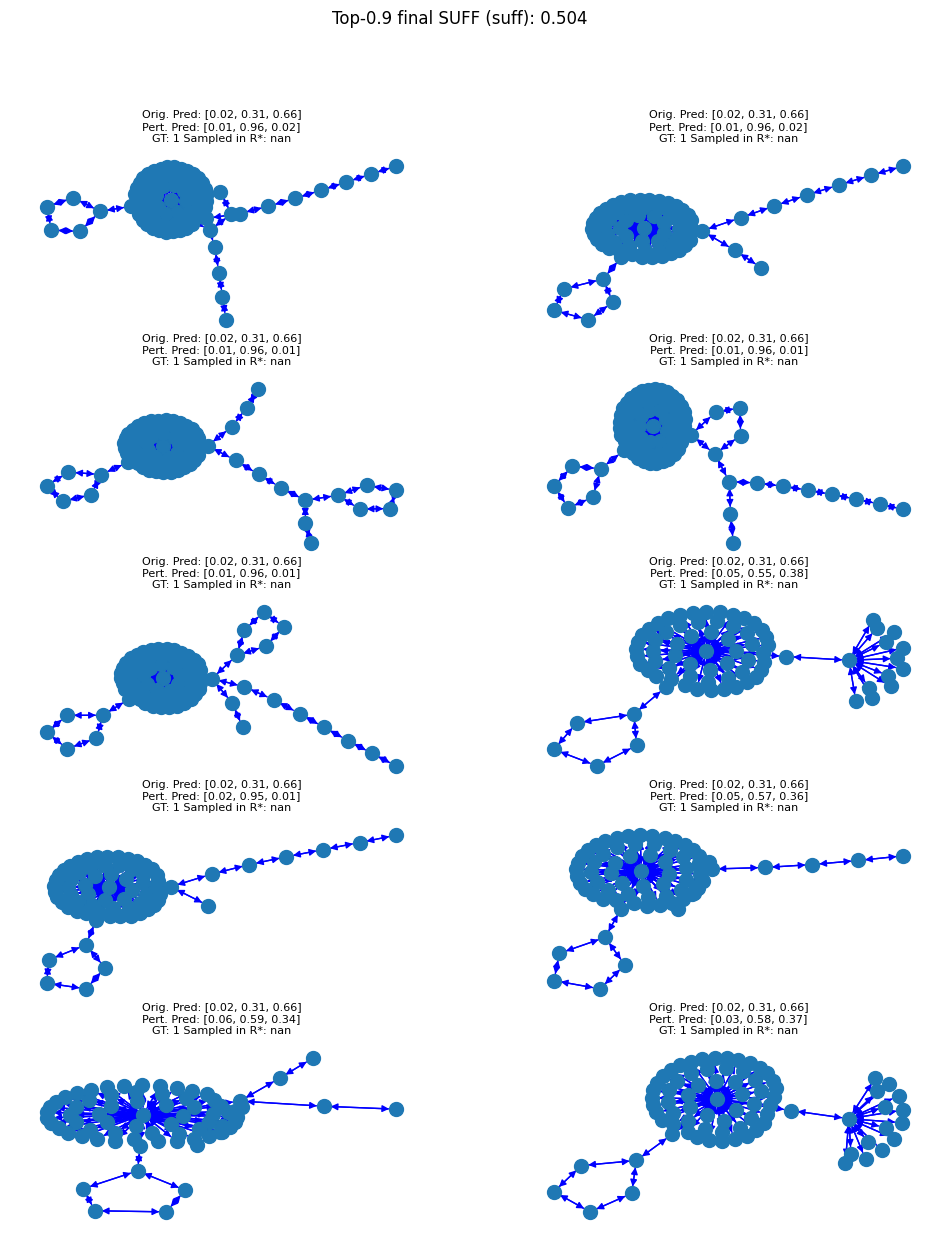

In [144]:
metric = "suff"
sample_method = "suff"

empty_idx = set()
sampled_G = []
num_samples = 10
orig_predictions = predict_sample([G], tested_pipeline, ratio=ratio).repeat_interleave(num_samples, dim=0)
for j in range(num_samples):
    config.random_seed = 304 + j
    reset_random_seed(config)
    
    G = graphs_nx[SPLIT][idx].copy()    

    if sample_method == "suff":
        G_filt = xai_utils.remove_from_graph(G, "spu", spu_subgraphs_r[SPLIT][ratio][idx])
        num_elem = xai_utils.mark_frontier(G, G_filt)
        if len(G_filt) == 0 or num_elem == 0:
            raise ValueError(f"{j} {num_elem}")
        G_union = None
        while G_union is None:
            G_union = tested_pipeline.get_intervened_graph(
                metric,
                "model_dependent",
                graphs_nx[SPLIT][j],
                empty_idx,
                causal_subgraphs_r[SPLIT][ratio][j],
                spu_subgraphs_r[SPLIT][ratio][j],
                G_filt,
                False,
                (idx, j, 0),
                feature_intervention=False,
                feature_bank=None
            )
            if G_union is None:
                j = j + 1
            else:
                print("Used ", j)
    else:
        G_union, _   = sample_edges(G, graphs[SPLIT][idx], None, spu_subgraphs_r[SPLIT][ratio][idx], ratio=1, num_to_remove=int((1-alpha)*avg_graph_size[SPLIT]), remove_undirected=False)
    
    sampled_G.append((G_union, np.nan))    
predictions = predict_sample([s[0] for s in sampled_G], tested_pipeline, ratio=ratio)


# Compute NEC
div = torch.nn.KLDivLoss(reduction="none", log_target=True)(orig_predictions, predictions).sum(-1)
aggr = torch.exp(-scatter_mean(div, torch.zeros(predictions.shape[0], dtype=int, device=predictions.device), dim=0)) 

predictions = torch.exp(predictions) # undo the log_softmax
orig_predictions = torch.exp(orig_predictions)
n_row = num_samples // 2
fig, axs = plt.subplots(n_row, 2, figsize=(12,14))
for j in range(num_samples):
    ax = axs[j // 2, j % 2]
    draw(config, sampled_G[j][0], name="", save=False, figsize=(3, 3), nodesize=100, with_labels=False, title=get_title_predition(orig_predictions, predictions, j, graphs[SPLIT][idx].y, sampled_G[j][1]), ax=ax);
plt.suptitle(f"Top-{ratio} final {metric.upper()} ({sample_method}): {round(aggr.item(), 3)}")
plt.show()

GT: tensor([1])
Selected 21 relevant edges over 34


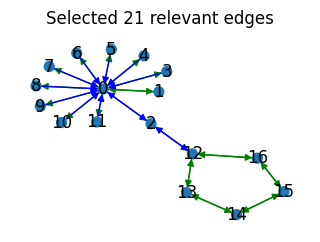

tensor([[0.0568, 0.8418, 0.1014]])
tensor([[0.0479, 0.8619, 0.0902]])
SUFF=3.414
Selected 20 relevant edges over 32


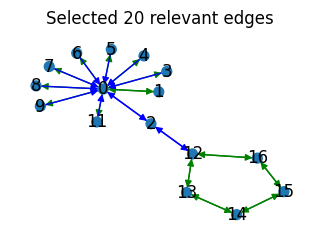

In [30]:
SPLIT = "val"
ratio = 0.6
idx = 0

G = graphs_nx[SPLIT][idx].copy()
xai_utils.mark_edges(G, causal_subgraphs_r[SPLIT][ratio][idx], spu_subgraphs_r[SPLIT][ratio][idx])
print(f"GT: {graphs[SPLIT][idx].y}")
pos = xai_utils.draw(config, G, name="", save=False, figsize=(3, 2), nodesize=50, with_labels=True);

original_prediction = predict_sample([G], tested_pipeline, ratio=ratio).exp()
print(original_prediction)

G_sampled, edges_in_gt = sample_edges(G, graphs[SPLIT][idx], 0.9, causal_subgraphs_r[SPLIT][ratio][idx], ratio=ratio, edge_remove=[(10,0)])
sampled_prediction = predict_sample([G_sampled], tested_pipeline, ratio=ratio)
print(sampled_prediction.exp())

div = torch.nn.KLDivLoss(reduction="none", log_target=True)(original_prediction, sampled_prediction).sum(-1)
aggr = torch.exp(-scatter_mean(div, torch.zeros(sampled_prediction.shape[0]).long(), dim=0)).mean().item()
print(f"SUFF={aggr:.3f}")

xai_utils.draw(config, G_sampled, name="", save=False, figsize=(3, 2), nodesize=50, with_labels=True, pos=pos);

